In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
import numpy as np

Using TensorFlow backend.


Define the mixture density layer by extending the dense layer and overriding the call method:

In [105]:
class MixtureDensity(Dense):
    
    def __init__(self, output_dim, n_gaussians, **kwargs):
        self.output_dim = (output_dim + 2) * n_gaussians
        self.n_gaussians = n_gaussians
        super(MixtureDensity, self).__init__(output_dim=self.output_dim,
                                             **kwargs)
        
    def call(self, x, mask=None):
        mult = K.dot(x, self.W) + self.b
        NG = self.n_gaussians
        # subtract largest value to help stability
        alpha = K.softmax(mult[:, :NG] - K.max(mult[:, :NG]))
        # add small value also for stability
        sigma = K.exp(mult[:, NG:2*NG]) + 0.001
        mu = mult[:,2*NG:]
        return K.concatenate([alpha, sigma, mu])

To conform to the Keras API, we use a closer to define the loss function. Note: the loss below is contrary to the Keras documentation which says that the loss function takes two tensors of the same shape. There's no check for that however, so we can just pass in the targets and our mixture layer output which have different sizes. This is required as the mixture layer doesn't output predictions, but a parametrized probability distribution, from which the loss must be computed.

In [106]:
def mdn_loss(NOUTPUTS, NGAUSSIAN):
    NG = NGAUSSIAN
    c = NOUTPUTS
    constant = 1.0 / np.power(2*np.pi, c/2.0) # normal dist normalization constant
    
    def keras_loss(t, net_pred):
        # extract parameters and reshape for computation
        alpha_op = net_pred[:, :NG]   
        sigma_op = net_pred[:, NG:2*NG]
        mu_op = net_pred[:, 2*NG:]
        reshape_mu = K.reshape(mu_op, (-1, NG, c))
        reshape_t = K.reshape(K.tile(t, [1, NG]), (-1, NG, c))
    
        # evaluate multivariate pdf on targets t
        squares = K.square(reshape_mu - reshape_t) 
        norm_sq = K.sum(squares, axis=2)
        inv_sigma_sq = 1.0 / (K.square(sigma_op))
        div = -0.5 * norm_sq * inv_sigma_sq
        sigma_pow = K.pow(sigma_op, c)
        final = constant * K.exp(div) * (1.0 / sigma_pow)

        # compute neg log loss
        weighted = final * alpha_op
        prob = K.sum(weighted, axis=1)
        logprob = -K.log(prob)
        return logprob
    
    return keras_loss

<h3> Simple Inverse Example </h3>

In [ ]:
NSAMPLE = 5000
NGAUSSIAN = 20
NOUTPUTS = 1
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE, 1)))
y_data = np.float32(np.sin(0.75 * x_data) * 7.0 + x_data * 0.5 + r_data * 1.0)

#invert training data
temp_data = x_data
x_data = y_data
y_data = temp_data

model = Sequential()
model.add(Dense(128,input_shape=(1,)))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(MixtureDensity(NOUTPUTS,NGAUSSIAN))

opt = Adam(lr=0.0001)

model.compile(loss=mdn_loss(NOUTPUTS,NGAUSSIAN), optimizer=opt)

model.fit(x_data, y_data, batch_size=128, nb_epoch=200, verbose=1)

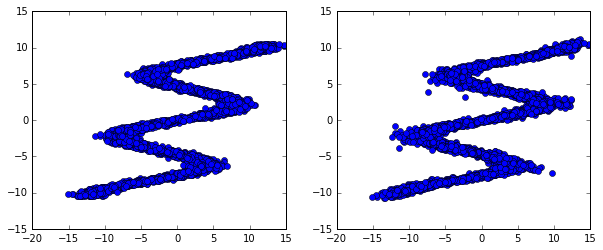

In [115]:
def sample_model():
    params = model.predict_on_batch(x_data)
    alpha = params[:, :NGAUSSIAN]
    sigma = params[:, NGAUSSIAN:2*NGAUSSIAN]
    mu = params[:, 2*NGAUSSIAN:]

    samples = np.zeros((NSAMPLE, NOUTPUTS))

    for i in range(NSAMPLE):
        alpha_idx = np.random.choice(NGAUSSIAN, size=1, p=alpha[i])[0]
        s_sigma = sigma[i, alpha_idx]
        mu_idx = alpha_idx * NOUTPUTS
        s_mu = mu[i, mu_idx:mu_idx + NOUTPUTS]
        cov = np.diag([s_sigma ** 2] * NOUTPUTS)
        samples[i, :] =  np.random.multivariate_normal(s_mu, cov)
    return samples

samples = sample_model()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(121, adjustable='box', aspect=1)
plt.plot(x_data, y_data, "o")
plt.subplot(122, adjustable='box', aspect=1)
plt.plot(x_data, samples, "o")
plt.show()

<h3> Inverse Kinematics Example </h3>

In [ ]:
NSAMPLE = 5000
NGAUSSIAN = 2
NOUTPUTS = 2

def create_dataset():
    L1, L2 = 0.8, 0.2
    theta1 = np.float32(np.random.uniform(0.3, 1.2, (NSAMPLE, 1)))
    theta2 = np.float32(np.random.uniform(np.pi/2, 3*np.pi/2, (NSAMPLE, 1)))
    joint_data = np.concatenate([theta1, theta2], axis=1)
    x1 = np.float32(L1 * np.cos(theta1) - L2 * np.cos(theta1 + theta2))
    x2 = np.float32(L1 * np.sin(theta1) - L2 * np.sin(theta1 + theta2))
    end_data = np.concatenate([x1, x2], axis=1)

    #invert training data
    temp_data = joint_data
    x_data = end_data
    y_data = temp_data
    return x_data, y_data

x_data, y_data = create_dataset()

model = Sequential()
model.add(Dense(128, input_shape=(2,)))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(MixtureDensity(NOUTPUTS,NGAUSSIAN))

opt = Adam(lr=0.0001)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

model.compile(loss=mdn_loss(NOUTPUTS,NGAUSSIAN), optimizer=opt)
model.fit(x_data, y_data, batch_size=128, nb_epoch=1000, verbose=1, 
          validation_split=0.3, callbacks=[early_stopping])

Now we create a test dataset and look at the RMS error of the model (similar to Figure 15 in the paper):

RMSE:  0.0802603


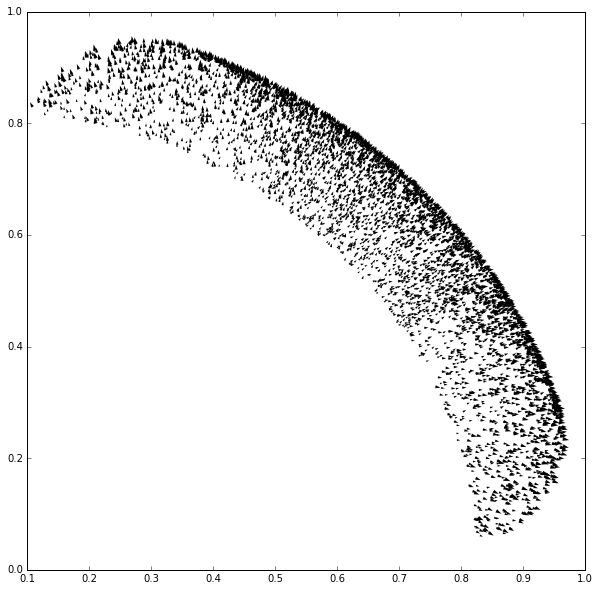

In [118]:
end_data, joint_data = create_dataset()
model_joint = sample_model()
theta1, theta2 = model_joint[:, 0], model_joint[:, 1]

# compute the forward mapping to compute rmse
x1 = np.float32(L1 * np.cos(theta1) - L2 * np.cos(theta1 + theta2))
x2 = np.float32(L1 * np.sin(theta1) - L2 * np.sin(theta1 + theta2))
model_end = np.vstack([x1, x2]).T

from sklearn.metrics import mean_squared_error as MSE
print("RMSE: ", MSE(end_data, model_end))

errors = end_data  - model_end
vectors = np.concatenate([end_data, end_data + errors], axis=1)
X, Y, U, V = zip(*vectors)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.quiver(X, Y, U, V)
plt.show()